## A Deep Learning Method For Solving Fokker-Planck Equations
### Jiayu Zhai, Matthew Dobson, Yao Li
This paper motivates and introduces a neural network for solving the stochastic PDE known as the Fokker-Planck equation. Their model achieves better accuracy at estimating the probability density function (PDF) of the invariant measure compared to a Monte-Carlo approximation, linear projection, and linear approximation methods.

## Motivation: What is an SDE? What is the Fokker-Planck Equation?
Stochastic differential equations (SDEs) are like normal differential equations, except that there is some random noise (i.e., Brownian motion aka Wiener Process). The solutions to SDEs are stochastic processes, not functions like normal DEs. A general SDE (aslo called an Itô process) can be modeled as follows:
$$
dX_t = \mu(X_t, t)dt + \sigma(X_t, t)dW_t
$$
$\mu(X_t, t)dt$ our drift function with respect to time.

$\sigma(X_t, t)dW_t$ is our diffusion function. Note that Wiener processes are not differentiable in the traditional sense. $dW_t$ represents an infitesemially small, random increment of the Wiener process $W_t$ over time.

Drift is the deterministic part of our SDE, and diffusion is stochastic (i.e., randomness proportional to the increment of a Wiener process). Notice that when $\sigma = 0$ our SDE reduces to a deterministic DE.

**The Fokker-Planck Equation**

The Fokker-Planck equation or the Kolmogorov forward equation describes the time evolution of the PDF for a stochastic process. Basically, it describes how our stochastic process changes (shape, spread, shift) over time. It is described as follows
$$
u_t = {L}u = -\sum_{i=1}^n \frac{\partial}{\partial x_i} (f_i u) + \frac{1}{2} \sum_{i,j=1}^n \frac{\partial^2}{\partial x_i \partial x_j} (\Sigma_{i,j} u)
$$
$L$ is the Fokker-Planck operator applied to our PDF $u$.

The first negated summation is our drift term, and the second summation is our diffusion term. $\Sigma = \sigma^T \sigma$ in the diffusion term is our diffusion matrix (also known as the covariance matrix) where $ \sigma$ is the diffusion coefficient matrix from the SDE.

Like many DEs, SDEs are usually very hard or impossible to solve analytically. Many numerical approximators exist, such as one described below.

## Solver 1: Monte-Carlo simulation and the Euler-Maruyama Approximation
I promise I'm not trying to spew a bunch of keywords!
The idea of Monte-Carlo simulation is we take a bunch of random trajectories of our SDE and treat those as samples from its invariant (stationary) distribution. We then estimate the density of this distribution.

In the world of traditional DEs, we have numerical approximations like the Euler method that define an iterative formula to find "steps" representing the slope of our function at a point in time, but how do we do this if we don't know where we're going (a familiar problem of late adolescene and early adulthood I can assure you)?

In the world of SDEs, a well-known numerical estimator for generating such an iterative formula is known as the Euler-Maruyama method:
$$
X_{n+1} = X_n + f(X_n)\Delta t + \sigma(X_n)\sqrt{\Delta t}\,Z_n
$$
Where $Z_n \sim N(0,I_d)$, $\sigma(X_n) \in R^{d \times d}$

$X_{n}$ is the step in our stochastic process, $f(X_n)\Delta{t}$ is our drift term and $\sigma(X_n)\sqrt{\Delta t}Z_n$ is our diffusion term.

We now have a way to define paths, and an idea about collecting states from said paths to estimate the PDF of our equation!

In [1]:
# Solver 1: Monte-Carlo simulation with Euler-Maruyama Approximation

import jax.numpy as jnp
from jax import random

# Drift functions
def drift_f_1(x, y):
  return (-4 * x) * (x**2 + y**2 - 1) + y

def drift_f_2(x, y):
  return (-4 * y) * (x**2 + y**2 - 1) - x

def drift(state):
  x, y = state
  return jnp.array([drift_f_1(x, y), drift_f_2(x, y)])

# Diffusion noise
# sigma = 1, so our covariance matrix is simply I_2
def diffusion_noise(key, dt):
  # returns sqrt(dt) * Z_n  where Z_n ~ N(0, I_2)
  z = random.normal(key, shape=(2,))
  return jnp.sqrt(dt) * z

# Euler-Maruyama Step
def em_step(state, key, dt):
  drift_val = drift(state)
  noise = diffusion_noise(key, dt)
  return state + drift_val * dt + noise

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [2]:
# Trajectory simulation
from jax import lax

def simulate_trajectory(key, x0, dt, n_steps):
  keys = random.split(key, n_steps)

  def body(state, k):
    state_next = em_step(state, k, dt)
    return state_next, state_next

  states = lax.scan(body, x0, keys)[1]  # states: (n_steps, 2)
  return states

# Burn-in and thinning
def burn_and_thin(states, burn_steps, thin):
  states = states[burn_steps:]
  return states[::thin]

In [3]:
# Histogram density
def hist2d_density(samples, xlim=(-2,2), ylim=(-2,2), bins=200):
  x = samples[:, 0]
  y = samples[:, 1]
  Nx = Ny = bins

  # Map to bin indices
  i = jnp.floor((x - xlim[0]) / (xlim[1] - xlim[0]) * Nx).astype(jnp.int32)
  j = jnp.floor((y - ylim[0]) / (ylim[1] - ylim[0]) * Ny).astype(jnp.int32)

  mask = (i >= 0) & (i < Nx) & (j >= 0) & (j < Ny)
  i, j = i[mask], j[mask]

  idx = i * Ny + j
  counts = jnp.bincount(idx, length=Nx*Ny).reshape((Nx, Ny))

  dx = (xlim[1]-xlim[0]) / Nx
  dy = (ylim[1]-ylim[0]) / Ny
  density = counts / (counts.sum() * dx * dy)

  x_centers = jnp.linspace(xlim[0], xlim[1], bins, endpoint=False) + dx/2
  y_centers = jnp.linspace(ylim[0], ylim[1], bins, endpoint=False) + dy/2
  return density, x_centers, y_centers

In [4]:
# Simulation Parameters
key = random.PRNGKey(0)

dt = 1e-3
n_steps = 10_000_000     # 1e7 for smoother density estimate
burn_steps = 50_000
thin = 10                # keeps ~ (n_steps-burn)/thin samples
x0 = jnp.array([0.0, 0.0])

states = simulate_trajectory(key, x0, dt, n_steps)
samples = burn_and_thin(states, burn_steps, thin)

density, xc, yc = hist2d_density(samples, xlim=(-2,2), ylim=(-2,2), bins=100)

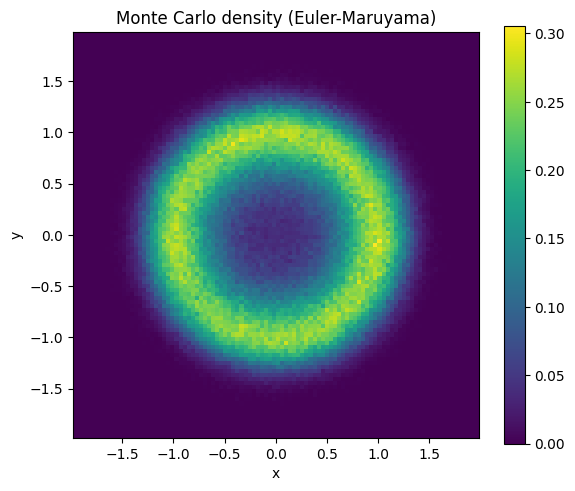

In [5]:
# Plot the density

import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.imshow(
    jnp.array(density).T,
    origin="lower",
    extent=[xc[0], xc[-1], yc[0], yc[-1]],
    aspect="equal",
)
plt.colorbar()
plt.title("Monte Carlo density (Euler-Maruyama)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


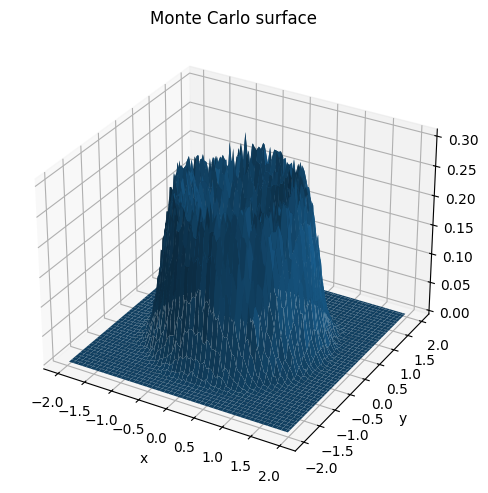

In [6]:
# 3D Surface approximation

X, Y = jnp.meshgrid(xc, yc, indexing="ij")
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(jnp.array(X), jnp.array(Y), jnp.array(density), rstride=2, cstride=2, linewidth=0)
ax.set_title("Monte Carlo surface")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tight_layout()
plt.show()

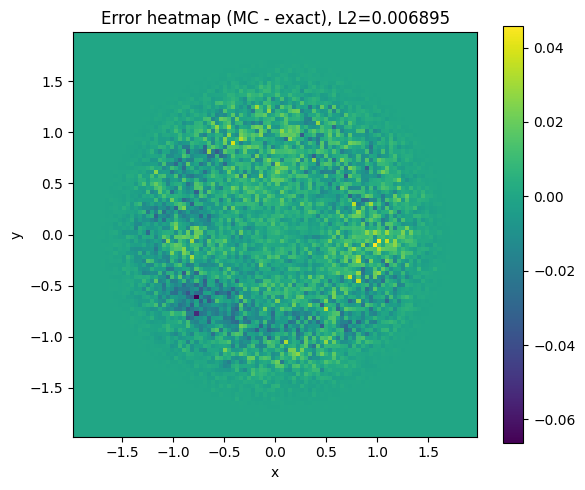

In [7]:
# Visualizing the error

def exact_ring_density(x, y, sigma=1.0):
    V = (x**2 + y**2 - 1.0)**2
    return jnp.exp(-2.0 * V / (sigma**2))

# Evaluate exact on grid centers and normalize on the box for comparison
Xg, Yg = jnp.meshgrid(xc, yc, indexing="ij")
u_unnorm = exact_ring_density(Xg, Yg, sigma=1.0)

dx = (xc[-1]-xc[0])/(len(xc)-1)  # approximate spacing
dy = (yc[-1]-yc[0])/(len(yc)-1)
u_exact = u_unnorm / (u_unnorm.sum() * dx * dy)

err = density - u_exact
l2 = jnp.sqrt(jnp.mean(err**2))

plt.figure(figsize=(6,5))
plt.imshow(
    jnp.array(err).T,
    origin="lower",
    extent=[xc[0], xc[-1], yc[0], yc[-1]],
    aspect="equal",
)
plt.colorbar()
plt.title(f"Error heatmap (MC - exact), L2={float(l2):.6f}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

## Solver 2: Implementing the Deep Neural Network

The idea here is that we represent the solution `u(x)` with a neural network and train it with both PDE and data loss


In [8]:
!pip install -q equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.7 MB/s eta 0:00:00


In [9]:
# Solver 2: Neural Network Fokker-Planck Solver
import jax
import equinox as eqx
import optax

class FPNet(eqx.Module):
  """
  Architecture from Appendix D.1: 
  6 hidden layers [16, 128, 128, 128, 16, 4], sigmoid activations, 1 scalar output
  """
  layers: list

  def __init__(self, key):
    keys = jax.random.split(key, 7)
    self.layers = [
        eqx.nn.Linear(2, 16, key=keys[0]),
        eqx.nn.Linear(16, 128, key=keys[1]),
        eqx.nn.Linear(128, 128, key=keys[2]),
        eqx.nn.Linear(128, 128, key=keys[3]),
        eqx.nn.Linear(128, 16, key=keys[4]),
        eqx.nn.Linear(16, 4, key=keys[5]),
        eqx.nn.Linear(4, 1, key=keys[6]),
    ]

  def __call__(self, xy):
    x = xy
    for layer in self.layers[:-1]:
      x = jax.nn.sigmoid(layer(x))
    return self.layers[-1](x).squeeze(-1)

model = FPNet(key=random.PRNGKey(42))

In [10]:
# Fokker-Planck operator Lu via JAX autodiff
#
# See sections 2.1 and 2.2 for definitions of the operator LU
#
# For a single point (x, y), we define scalar functions of (x, y)
# and differentiate with jax.grad.

def u_hat_scalar(mdl, x, y):
  """
  Network output as a function of two scalar inputs
  """
  return mdl(jnp.array([x, y]))

def fokker_planck_residual(mdl, x, y):
  """
  Compute Lu at a single point (x, y)
  """

  # u and its first derivatives
  u = u_hat_scalar(mdl, x, y)
  du_dx = jax.grad(u_hat_scalar, argnums=1)(mdl, x, y)
  du_dy = jax.grad(u_hat_scalar, argnums=2)(mdl, x, y)

  # Second derivatives (Laplacian terms)
  d2u_dx2 = jax.grad(jax.grad(u_hat_scalar, argnums=1), argnums=1)(mdl, x, y)
  d2u_dy2 = jax.grad(jax.grad(u_hat_scalar, argnums=2), argnums=2)(mdl, x, y)

  # Drift field
  f1 = drift_f_1(x, y)
  f2 = drift_f_2(x, y)

  # Derivatives of drift (for product rule)
  df1_dx = jax.grad(drift_f_1, argnums=0)(x, y)
  df2_dy = jax.grad(drift_f_2, argnums=1)(x, y)

  drift_term = -(df1_dx * u + f1 * du_dx) - (df2_dy * u + f2 * du_dy)
  diffusion_term = 0.5 * (d2u_dx2 + d2u_dy2)

  return drift_term + diffusion_term

# Vectorize over a batch of points
fokker_planck_residual_batch = jax.vmap(fokker_planck_residual, in_axes=(None, 0, 0))

In [ ]:
# Data preparation
Xg_ref, Yg_ref = jnp.meshgrid(xc, yc, indexing="ij")
XY_grid = jnp.stack([Xg_ref.ravel(), Yg_ref.ravel()], axis=-1)

X_train = XY_grid
Y_ref = XY_grid
v_ref = density.ravel()

print(f"Training set X: {X_train.shape}")
print(f"Reference set Y: {Y_ref.shape}, v_ref: {v_ref.shape}")
print(f"v_ref range: [{float(v_ref.min()):.4f}, {float(v_ref.max()):.4f}]")

Training set X: (10000, 2)
Reference set Y: (10000, 2), v_ref: (10000,)
v_ref range: [0.0000, 0.3053]


In [12]:
# Loss functions (Eq. 3.1) and JIT-compiled training steps
# L1: PDE residual loss
# L2: MSE between NN output and MC reference

def loss_L1(mdl, x_batch):
  """PDE loss: mean squared Fokker-Planck residual over training batch."""
  residuals = fokker_planck_residual_batch(mdl, x_batch[:, 0], x_batch[:, 1])
  return jnp.mean(residuals ** 2)

def loss_L2(mdl, y_batch, v_batch):
  """Data loss: mean squared error between NN output and MC reference."""
  u_pred = jax.vmap(mdl)(y_batch)
  return jnp.mean((u_pred - v_batch) ** 2)

# JIT-compiled training steps (one for each loss)
@eqx.filter_jit
def step_L1(mdl, opt_state, opt, x_batch):
  """One Adam step on L1."""
  grads = eqx.filter_grad(loss_L1)(mdl, x_batch)
  updates, opt_state = opt.update(grads, opt_state, eqx.filter(mdl, eqx.is_array))
  mdl = eqx.apply_updates(mdl, updates)
  return mdl, opt_state

@eqx.filter_jit
def step_L2(mdl, opt_state, opt, y_batch, v_batch):
  """One Adam step on L2."""
  grads = eqx.filter_grad(loss_L2)(mdl, y_batch, v_batch)
  updates, opt_state = opt.update(grads, opt_state, eqx.filter(mdl, eqx.is_array))
  mdl = eqx.apply_updates(mdl, updates)
  return mdl, opt_state

print("Loss functions and training steps defined.")

Loss functions and training steps defined.


In [ ]:
# Double-shuffling training (full-batch variant for now)

def train(mdl, X_train, Y_ref, v_ref,
          n_epochs=5000, lr=3e-4, log_every=250):
  """
  Differ from the paper by using full-batch updates, and asymmetric updates
  """

  opt1 = optax.adam(lr)
  opt2 = optax.adam(lr)
  opt_state1 = opt1.init(eqx.filter(mdl, eqx.is_array))
  opt_state2 = opt2.init(eqx.filter(mdl, eqx.is_array))

  for epoch in range(n_epochs):
    mdl, opt_state1 = step_L1(mdl, opt_state1, opt1, X_train)

    for _ in range(3):
      mdl, opt_state2 = step_L2(mdl, opt_state2, opt2, Y_ref, v_ref)

    if (epoch + 1) % log_every == 0 or epoch == 0:
      l1_val = float(loss_L1(mdl, X_train))
      l2_val = float(loss_L2(mdl, Y_ref, v_ref))
      print(f"Epoch {epoch+1:5d} | L1={l1_val:.6f} | L2={l2_val:.6f}")

  return mdl

print("Training function defined.")

Training function defined.


In [20]:
# Run training
# Re-initialize model for a fresh start
model = FPNet(key=random.PRNGKey(42))

trained_model = train(
    model, X_train, Y_ref, v_ref,
    n_epochs=5000,
    lr=3e-4,
    log_every=250,
)

# Final losses on full sets
final_L1 = float(loss_L1(trained_model, X_train))
final_L2 = float(loss_L2(trained_model, Y_ref, v_ref))
print(f"\nFinal L1={final_L1:.6f}, L2={final_L2:.6f}")

Epoch     1 | L1=1.689629 | L2=0.008871
Epoch   250 | L1=7.932742 | L2=0.007781
Epoch   500 | L1=7.194681 | L2=0.004110
Epoch   750 | L1=5.743154 | L2=0.003252
Epoch  1000 | L1=1.586126 | L2=0.002303
Epoch  1250 | L1=0.216335 | L2=0.000298
Epoch  1500 | L1=0.170107 | L2=0.000070
Epoch  1750 | L1=0.083547 | L2=0.000056
Epoch  2000 | L1=0.043365 | L2=0.000051
Epoch  2250 | L1=0.023104 | L2=0.000049
Epoch  2500 | L1=0.013012 | L2=0.000049
Epoch  2750 | L1=0.012812 | L2=0.000049
Epoch  3000 | L1=0.008786 | L2=0.000052
Epoch  3250 | L1=0.008282 | L2=0.000048
Epoch  3500 | L1=0.006912 | L2=0.000046
Epoch  3750 | L1=0.006528 | L2=0.000047
Epoch  4000 | L1=0.005986 | L2=0.000046
Epoch  4250 | L1=0.005659 | L2=0.000045
Epoch  4500 | L1=0.005533 | L2=0.000045
Epoch  4750 | L1=0.005642 | L2=0.000045
Epoch  5000 | L1=0.005700 | L2=0.000045

Final L1=0.005700, L2=0.000045


In [ ]:
# Evaluate NN on a 400x400 grid and compare with exact solution
eval_bins = 400
x_eval = jnp.linspace(-2, 2, eval_bins)
y_eval = jnp.linspace(-2, 2, eval_bins)
Xe, Ye = jnp.meshgrid(x_eval, y_eval, indexing="ij")
grid_pts = jnp.stack([Xe.ravel(), Ye.ravel()], axis=-1)

# Evaluate NN over the grid
nn_density_flat = jax.vmap(trained_model)(grid_pts)
nn_density = nn_density_flat.reshape(eval_bins, eval_bins)

# Normalize NN density on the evaluation grid
dx_eval = x_eval[1] - x_eval[0]
dy_eval = y_eval[1] - y_eval[0]
nn_density_norm = nn_density / (nn_density.sum() * dx_eval * dy_eval)

# Exact solution on evaluation grid
u_exact_eval = exact_ring_density(Xe, Ye, sigma=1.0)
u_exact_eval = u_exact_eval / (u_exact_eval.sum() * dx_eval * dy_eval)

# Error
err_nn = nn_density_norm - u_exact_eval
l2_nn = jnp.sqrt(jnp.mean(err_nn ** 2))

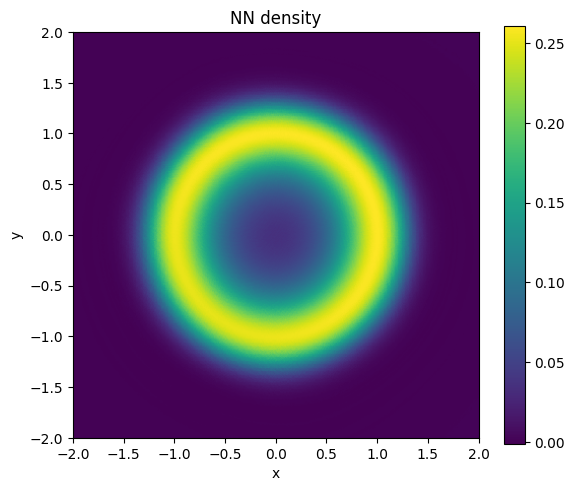


NN  L2 error: 0.002661


In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

im0 = ax.imshow(
    nn_density_norm.T,
    origin="lower",
    extent=[-2, 2, -2, 2],
    aspect="equal",
)
ax.set_title("NN density")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im0, ax=ax)
plt.tight_layout()
plt.show()

print(f"\nNN  L2 error: {float(l2_nn):.6f}")

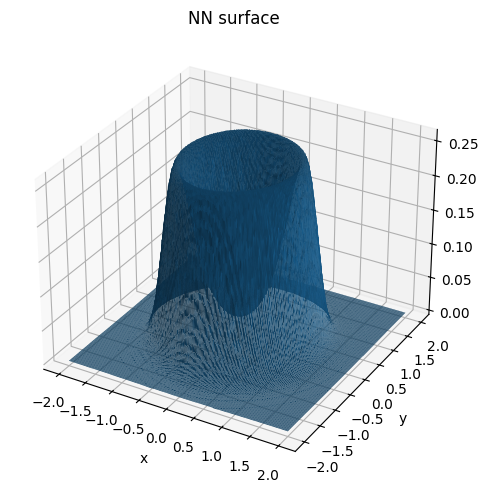

In [33]:
# 3D Surface approximation (NN)
X_nn, Y_nn = jnp.meshgrid(x_eval, y_eval, indexing="ij")
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(jnp.array(X_nn), jnp.array(Y_nn), jnp.array(nn_density_norm), rstride=2, cstride=2, linewidth=0)
ax.set_title("NN surface")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tight_layout()
plt.show()